In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import mplcyberpunk
from cycler import cycler
import matplotlib.pyplot as plt
plt.style.use("cyberpunk")
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from yellowbrick.target import FeatureCorrelation

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,roc_auc_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Import the input dataset
tracks_new = pd.read_csv('preprocessed_tracks.csv')
tracks_new.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,0,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922
1,0,98200,0,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922
2,0,181640,0,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922
3,0,176907,0,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922
4,0,163080,0,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922


In [3]:
tracks_new.shape

(586665, 16)

In [4]:
tracks_sample = tracks_new.sample(n=50000)

In [5]:
tracks_sample.shape

(50000, 16)

In [6]:
tracks_sample.tail()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
22166,0,94726,0,0.432,0.321,10,-10.552,0,0.0322,0.82400,0.027700,0.136,0.841,117.618,4,1948
84264,0,330333,0,0.442,0.950,1,-3.616,0,0.0621,0.00207,0.000000,0.141,0.433,139.978,4,2018
569282,0,243018,0,0.730,0.720,11,-6.451,1,0.0766,0.04910,0.000000,0.200,0.159,140.039,4,2017
248563,0,321093,0,0.515,0.954,2,-3.458,1,0.1660,0.36500,0.000000,0.958,0.623,125.222,4,1976
236451,0,283533,0,0.523,0.390,4,-9.290,1,0.0286,0.82100,0.000013,0.324,0.716,111.616,4,2001


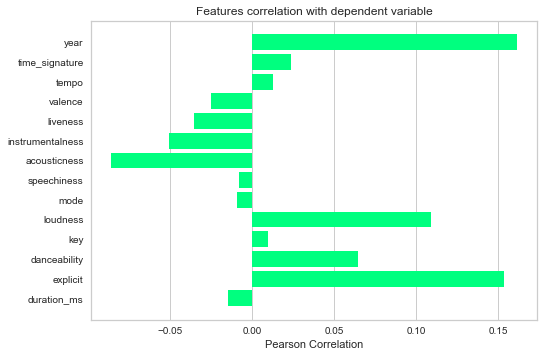

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [7]:
# As calculated in our EDA, loudeness is positively correlated with energy,so we are not including 'energy'
 
features = ['duration_ms', 'explicit', 'danceability',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','year']

X = tracks_sample[features]
y = tracks_sample.popularity

# Create a list of the feature names

features = np.array(features)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features,color='springgreen')
visualizer.fit(X, y)        # Fit the data to the visualizer
mplcyberpunk.add_glow_effects()
visualizer.show()

In [8]:
from sklearn.feature_selection import mutual_info_classif
mutual_info_classif(X,y)

array([0.00340079, 0.00614824, 0.0014919 , 0.00160364, 0.00771666,
       0.00751237, 0.00340299, 0.00629782, 0.00282952, 0.00129768,
       0.00042775, 0.00618634, 0.00911451, 0.0235384 ])

In [9]:
imp=pd.DataFrame(mutual_info_classif(X,y),index=X.columns)
imp.columns=['importance']
imp.sort_values(by='importance',ascending=False)

,importance
year,0.021425
time_signature,0.010918
loudness,0.008163
explicit,0.006864
tempo,0.006206
acousticness,0.006109
mode,0.004670
speechiness,0.003658
instrumentalness,0.003441
duration_ms,0.003295


0    48639
1     1361
Name: popularity, dtype: int64
----------------------------------------------------------------------------------------------------


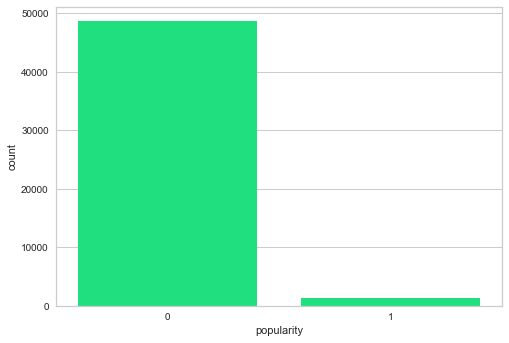

In [10]:
print(tracks_sample['popularity'].value_counts())
print('----'*25)
sns.countplot(x="popularity", data=tracks_sample,color='springgreen')
mplcyberpunk.add_glow_effects()
plt.show()

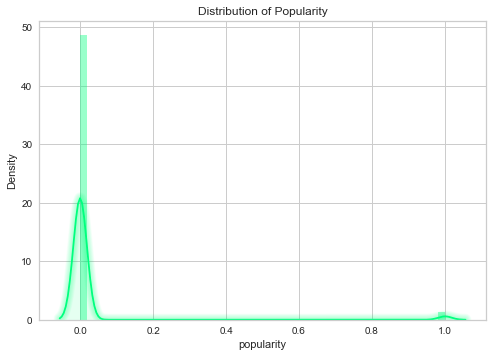

In [11]:
sns.distplot(tracks_sample['popularity'],color='springgreen')
plt.title("Distribution of Popularity")
mplcyberpunk.add_glow_effects()
plt.show()

In [12]:
# Balance the dataset using SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()
 

1    48639
0    48639
Name: popularity, dtype: int64

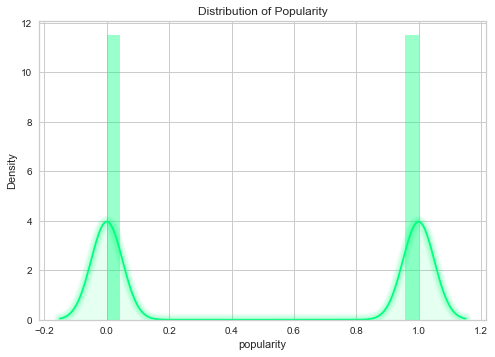

In [13]:
sns.distplot(y_sm,color='springgreen')
plt.title("Distribution of Popularity")
mplcyberpunk.add_glow_effects()
plt.show()

In [14]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, random_state=42,test_size=0.20,stratify=y_sm)
 
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train = X_scaler.transform(X_train) 
X_test = X_scaler.transform(X_test)

### Model Building 
 - 1. Calculate the Accuracy.
 - 2. Check the Performance of the model with Confusion Matrix

#### Why to use both?
Because,Confusion matrices give a better idea of a model’s performance than classification accuracy does.
Good model should always have high performance in predicting True Positives and True Negatives. 
 

In [15]:
# Logistic Regression
LR_Model = LogisticRegression(solver="lbfgs",max_iter=100)
LR_Model.fit(X_train, y_train)
LR_Predict = LR_Model.predict(X_test)
LR_Accuracy = accuracy_score(y_test, LR_Predict)
print("Accuracy: ",LR_Accuracy)
print('---'*25)
LR_matrix = confusion_matrix(y_test, LR_Predict)
print("Confusion Matrix for LR_Model :\n",LR_matrix) 


Accuracy:  0.7774465460526315
---------------------------------------------------------------------------
Confusion Matrix for LR_Model :
 [[7066 2662]
 [1668 8060]]


In [16]:
# Decision Tree Classifier
DT_Model = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5)
DT_Model.fit(X_train, y_train)
DT_Predict = DT_Model.predict(X_test)
DT_Accuracy = accuracy_score(y_test, DT_Predict)
print("Accuracy: ",DT_Accuracy)
print('---'*25)
DT_matrix = confusion_matrix(y_test, DT_Predict)
print("Confusion Matrix for KNN_Model :\n",DT_matrix) 

Accuracy:  0.8925267269736842
---------------------------------------------------------------------------
Confusion Matrix for KNN_Model :
 [[8342 1386]
 [ 705 9023]]


In [17]:
# Random Forest Classifier
RFC_Model = RandomForestClassifier(n_estimators=100,
                                 min_samples_split=5,
                                 min_samples_leaf=1,
                                 max_features='auto',
                                 max_depth=30)
RFC_Model.fit(X_train, y_train)
RFC_Predict = RFC_Model.predict(X_test)
RFC_Accuracy = accuracy_score(y_test, RFC_Predict)
print("Accuracy: ",RFC_Accuracy)
print('---'*25)
RFC_matrix = confusion_matrix(y_test, RFC_Predict)
print("Confusion Matrix for KNN_Model :\n",DT_matrix) 

Accuracy:  0.9506578947368421
---------------------------------------------------------------------------
Confusion Matrix for KNN_Model :
 [[8342 1386]
 [ 705 9023]]


In [18]:
# K-nearest neighbors
KNN_Model = KNeighborsClassifier(n_neighbors = 5, weights = 'distance',algorithm = 'brute',metric = 'manhattan')
KNN_Model.fit(X_train, y_train)
KNN_Predict = KNN_Model.predict(X_test)
KNN_Accuracy = accuracy_score(y_test, KNN_Predict)
print("Accuracy: ",KNN_Accuracy)
print('---'*25)
KNN_matrix = confusion_matrix(y_test, KNN_Predict)
print("Confusion Matrix for KNN_Model :\n",KNN_matrix) 

Accuracy:  0.8943256578947368
---------------------------------------------------------------------------
Confusion Matrix for KNN_Model :
 [[7708 2020]
 [  36 9692]]


In [19]:
# XGBoost
XGB_Model = XGBClassifier()
XGB_Model.fit(X_train, y_train,eval_metric='rmse')
XGB_Predict = XGB_Model.predict(X_test)
XGB_Accuracy = accuracy_score(y_test, XGB_Predict)
print("Accuracy: ",XGB_Accuracy)
print('---'*25)
XGB_matrix = confusion_matrix(y_test, XGB_Predict)
print("Confusion Matrix for XGB_Model :\n",XGB_matrix) 

Accuracy:  0.926500822368421
---------------------------------------------------------------------------
Confusion Matrix for XGB_Model :
 [[8687 1041]
 [ 389 9339]]


In [20]:
#Support Vector Machine
from sklearn.svm import SVC
SVC_Model = SVC()
SVC_Model.fit(X_train, y_train)
SVC_Predict = SVC_Model.predict(X_test)
SVC_Accuracy = accuracy_score(y_test, SVC_Predict)
print("Accuracy: ",SVC_Accuracy)
print('---'*25)
SVC_matrix = confusion_matrix(y_test, SVC_Predict)
print("Confusion Matrix for SVC_Model :\n",SVC_matrix) 

Accuracy:  0.8572676809210527
---------------------------------------------------------------------------
Confusion Matrix for SVC_Model :
 [[7943 1785]
 [ 992 8736]]


In [21]:
# Compare Accuracy
model_performance_accuracy = pd.DataFrame({'Model': ['LogisticRegression', 
                                                     'DecisionTreeClassifier',
                                                     'RandomForestClassifier', 
                                                     'KNeighborsClassifier',
                                                     'XGBClassifier',
                                                     'SVC'],
                                            'Accuracy': [LR_Accuracy,
                                                         DT_Accuracy,
                                                         RFC_Accuracy,
                                                         KNN_Accuracy,
                                                         XGB_Accuracy,
                                                         SVC_Accuracy]})

In [22]:
# Which algorithm gives the maximum accuracy?
model_performance_accuracy.sort_values(by = "Accuracy", ascending = False)

,Model,Accuracy
2,RandomForestClassifier,0.950658
4,XGBClassifier,0.926501
3,KNeighborsClassifier,0.894326
1,DecisionTreeClassifier,0.892527
5,SVC,0.857268
0,LogisticRegression,0.777447


- Out of all the models, the highest accuracy is achieved by Random Forest Classifier

In [23]:
# What is Precision and recall?
from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(y_test, RFC_Predict))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      9728
           1       0.93      0.97      0.95      9728

    accuracy                           0.95     19456
   macro avg       0.95      0.95      0.95     19456
weighted avg       0.95      0.95      0.95     19456



### Save the Model

In [24]:
# save the model 
import pickle 
pickle_out = open("deploy.pkl", mode = "wb") 
pickle.dump(RFC_Model, pickle_out) 
pickle_out.close()

In [25]:
import numpy as np 
import pickle

pickle_in = open('deploy.pkl', 'rb')

RFC_Model = pickle.load(pickle_in)
 
data = np.array([208216,1,0.626,10,7.0851,1,0.147,0.138,0.312,0.095,0.65,7.715,4,2020])
data = data.reshape(1,-1)

pre = RFC_Model.predict(data)
print(pre) 

[0]


In [26]:
#Actual Vs Predicted
data2 = pd.DataFrame({'Actual Points': y_test.tolist(), 'Predicted Points': RFC_Predict.tolist()})
data2.head(10).style.background_gradient(cmap='Greens')

,Actual Points,Predicted Points
0,0,0
1,0,1
2,1,1
3,0,0
4,1,0
5,0,0
6,0,0
7,0,1
8,1,1
9,1,1
